<a href="https://colab.research.google.com/github/pedrovsglima/python-neural-networks/blob/main/coursera/PyTorch_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro Task, Object Localization

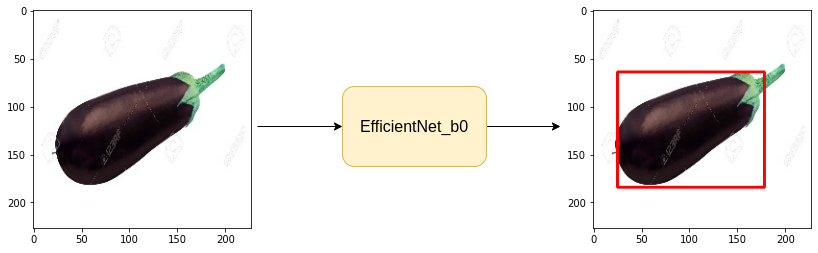

In [1]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-u6dt5m4g
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-u6dt5m4g
  Resolved https://github.com/albumentations-team/albumentations to commit de2f0ccdd324c18ab2a30b6e9ef405ded260e272
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 43.9 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-1.4.11-py3-none-any.whl size=165289 sha256=e44354594997736ce8f210e80de57d31945c7dc0e34a4a9ba9a52d4881652991
  Stored in directory: /tmp/pip-ephem-wheel-cache-hbe9s325/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4a

In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 5.44 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [6]:
df = pd.read_csv(CSV_FILE)
df.head(10)

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
5,train_images/mushroom_12.jpg,87,21,205,193,227,227,mushroom
6,train_images/eggplant_6.jpg,24,83,222,144,227,227,eggplant
7,train_images/mushroom_1.jpg,44,66,155,167,227,227,mushroom
8,train_images/cucumber_62.jpg,21,26,207,185,227,227,cucumber
9,train_images/cucumber_60.jpg,55,58,219,201,227,227,cucumber


# Understand the dataset

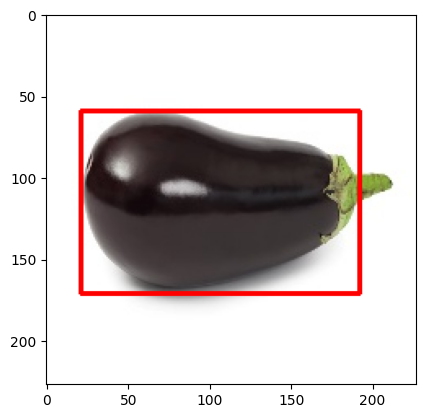

In [15]:
row = df.iloc[184]
img = cv2.imread(DATA_DIR + row['img_path'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pt1 = (row['xmin'], row['ymin'])
pt2 = (row['xmax'], row['ymax'])
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255,0,0), 2)

plt.imshow(bnd_box_img)

In [16]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

In [18]:
import albumentations as A

In [19]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [20]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self, df, augmentations=None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    xmin = row['xmin']
    ymin = row['ymin']
    xmax = row['xmax']
    ymax = row['ymax']

    bbox = [[xmin, ymin, xmax, ymax]]

    img_path = DATA_DIR + row['img_path']
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image=img, bboxes=bbox, class_labels=[None])
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2, 0, 1) / 255.0 # (h, w, c) - > c, h, w
    bbox = torch.Tensor(bbox)

    return img, bbox

In [21]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [23]:
print("Total examples in the trainset:", len(trainset))
print("Total examples in the validset:", len(validset))

Total examples in the trainset: 148
Total examples in the validset: 38


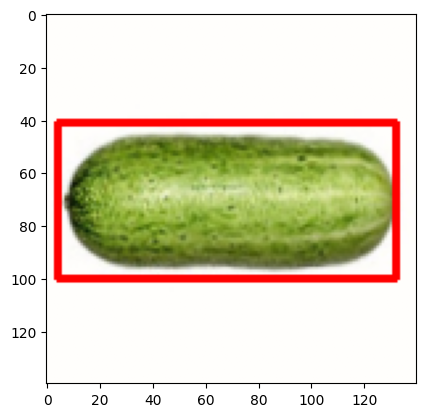

In [26]:
img, bbox = trainset[19]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(), pt1, pt2, (255,0,0), 2)
plt.imshow(bnd_img)

# Load dataset into batches

In [27]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [30]:
for images, bboxes in trainloader:
  print("Shape of one batch images : {}".format(images.shape))
  print("Shape of one batch bboxes : {}".format(bboxes.shape))
  break

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn
import timm

# Create Train and Eval Function

#Training Loop

#Inference

In [ ]:
import utils

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya